Importation des modules

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme() # permet d'obtenir le fonc gris avec les lignes blanches
import plotly.express as px

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, to_tree, cut_tree
from scipy.spatial.distance import pdist, squareform

from sklearn import metrics # for evaluations
from sklearn.datasets import make_blobs, make_circles # for generating experimental data
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



# Partie 2 - Composition d'une liste de produits alimentaires

## Préparation et importation des données

On importe les données.

In [20]:
food = pd.read_csv("https://perso.univ-rennes1.fr/valerie.monbet/ISD/FoodComposition.csv",
                   sep=";")
food.head()

,NDB_No,Shrt_Desc,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),...,Vit_K_(µg),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),GmWt_1,GmWt_Desc1,GmWt_2,GmWt_Desc2,Refuse_Pct
0,1001,BUTTER.WITH SALT,15.87,717,0.85,81.11,2.11,0.06,0.0,0.06,...,7.0,51.368,21.021,3.043,215.0,5.0,"1 pat. (1"" sq. 1/3"" high)",14.2,1 tbsp,0.0
1,1002,BUTTER.WHIPPED.WITH SALT,15.87,717,0.85,81.11,2.11,0.06,0.0,0.06,...,7.0,50.489,23.426,3.012,219.0,3.0,"1 pat. (1"" sq. 1/3"" high)",9.4,1 tbsp,0.0
2,1003,BUTTER OIL.ANHYDROUS,0.24,876,0.28,99.48,0.00,0.00,0.0,0.00,...,8.6,61.924,28.732,3.694,256.0,12.0,1 tbsp,205.0,1 cup,0.0
3,1004,CHEESE.BLUE,42.41,353,21.40,28.74,5.11,2.34,0.0,0.50,...,2.4,18.669,7.778,0.800,75.0,28.0,1 oz,17.0,1 cubic inch,0.0
4,1005,CHEESE.BRICK,41.11,371,23.24,29.68,3.18,2.79,0.0,0.51,...,2.5,18.764,8.598,0.784,94.0,132.0,1 cup. diced,113.0,1 cup. shredded,0.0


et on les prépare pour le TP.

In [21]:
def preprocessing(food,num_etud=1,N = 50):
  X = food._get_numeric_data()
  X = X.rename(index=food["Shrt_Desc"])
  coln = X.columns.to_list()
  # on retire une partie des variables
  list_for_removing =  ['NDB_No','Iron_(mg)', 'Magnesium_(mg)', 'Phosphorus_(mg)', 'Potassium_(mg)',  'Zinc_(mg)',
                        'Copper_mg)', 'Manganese_(mg)', 'Selenium_(µg)', 'Thiamin_(mg)', 'Riboflavin_(mg)',
                        'Niacin_(mg)', 'Panto_Acid_mg)', 'Vit_B6_(mg)', 'Folate_Tot_(µg)', 'Folic_Acid_(µg)',
                        'Food_Folate_(µg)', 'Folate_DFE_(µg)', 'Choline_Tot_ (mg)', 'Vit_B12_(µg)',
                        'Vit_A_IU', 'Vit_A_RAE', 'Retinol_(µg)', 'Alpha_Carot_(µg)', 'Beta_Carot_(µg)',
                        'Beta_Crypt_(µg)', 'Lycopene_(µg)', 'Lut+Zea_ (µg)', 'Vit_E_(mg)', 'Vit_D_µg',
                        'Vit_D_IU', 'Vit_K_(µg)','GmWt_1','GmWt_2','Refuse_Pct']
  X = X.drop(columns=list_for_removing)
  ij_na = np.where(np.isnan(X))
  nb_na_row = [np.sum(ij_na[0]==i) for i in np.unique(ij_na[0])]
  kc = np.where(np.asarray(nb_na_row)>0)
  unique_values_kc = np.unique(ij_na[0])[kc]
  Xpd = pd.DataFrame(X)
  # Remove lines from X based on unique_values_kc
  Xc = Xpd.drop(food["Shrt_Desc"][unique_values_kc], axis=0)
  ij_na = np.where(np.isnan(Xc))
  nb_na_col = [np.sum(ij_na[1]==i) for i in np.unique(ij_na[1])]
  kc = np.where(np.asarray(nb_na_col)>1000)
  unique_values_kc = np.unique(ij_na[1])[kc]
  Xpd = pd.DataFrame(Xc)
  colnames = [x for x in Xpd.columns.to_list() if x not in Xpd.columns[unique_values_kc].to_list()]
  # Remove lines from X based on unique_values_kc
  Xc = Xpd.drop(Xpd.columns[unique_values_kc], axis=1)
  imputer = KNNImputer(n_neighbors=10,
                      weights="distance")
  Xci = imputer.fit_transform(Xc)
  n = Xci.shape[0]
  np.random.seed(seed=num_etud)
  ii =  np.random.randint(n, size=(N,))
  Xsubset = Xci[ii,:]
  Xsubset = pd.DataFrame(Xsubset)
  Xsubset.columns = colnames
  noms = Xc.index.to_list()
  noms_subset = [noms[i] for i in ii]
  Xsubset.index = noms_subset

  return Xsubset


In [22]:
Xsubset = preprocessing(food,num_etud=20102965) # ici remplacer par votre numero d'étudiant.

In [23]:
Xsubset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, OSCAR MAYER.WIENERS (BEEF FRANKS) to CHICKEN.BROILERS OR FRYERS.LT MEAT.MEAT ONLY.RAW
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Water_(g)       50 non-null     float64
 1   Energ_Kcal      50 non-null     float64
 2   Protein_(g)     50 non-null     float64
 3   Lipid_Tot_(g)   50 non-null     float64
 4   Ash_(g)         50 non-null     float64
 5   Carbohydrt_(g)  50 non-null     float64
 6   Fiber_TD_(g)    50 non-null     float64
 7   Sugar_Tot_(g)   50 non-null     float64
 8   Calcium_(mg)    50 non-null     float64
 9   Sodium_(mg)     50 non-null     float64
 10  Vit_C_(mg)      50 non-null     float64
 11  FA_Sat_(g)      50 non-null     float64
 12  FA_Mono_(g)     50 non-null     float64
 13  FA_Poly_(g)     50 non-null     float64
 14  Cholestrl_(mg)  50 non-null     float64
dtypes: float64(15)
memory usage: 6.2+ KB


A partir d'ici, écrire le code permettant de répondre aux questions.

**Q1 :**

In [24]:
Xsubset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, OSCAR MAYER.WIENERS (BEEF FRANKS) to CHICKEN.BROILERS OR FRYERS.LT MEAT.MEAT ONLY.RAW
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Water_(g)       50 non-null     float64
 1   Energ_Kcal      50 non-null     float64
 2   Protein_(g)     50 non-null     float64
 3   Lipid_Tot_(g)   50 non-null     float64
 4   Ash_(g)         50 non-null     float64
 5   Carbohydrt_(g)  50 non-null     float64
 6   Fiber_TD_(g)    50 non-null     float64
 7   Sugar_Tot_(g)   50 non-null     float64
 8   Calcium_(mg)    50 non-null     float64
 9   Sodium_(mg)     50 non-null     float64
 10  Vit_C_(mg)      50 non-null     float64
 11  FA_Sat_(g)      50 non-null     float64
 12  FA_Mono_(g)     50 non-null     float64
 13  FA_Poly_(g)     50 non-null     float64
 14  Cholestrl_(mg)  50 non-null     float64
dtypes: float64(15)
memory usage: 6.2+ KB


**Q2 :**

In [25]:
scale = StandardScaler()
Xsubset_2 = scale.fit_transform(Xsubset)  # Xsubset_2 est un tableau numpy

#On le convertit en datafame :
df_Xsubset_2 = pd.DataFrame(Xsubset_2, columns=Xsubset.columns)

# **Classification Ascendante Hiérarchique :**

**Q3 :**

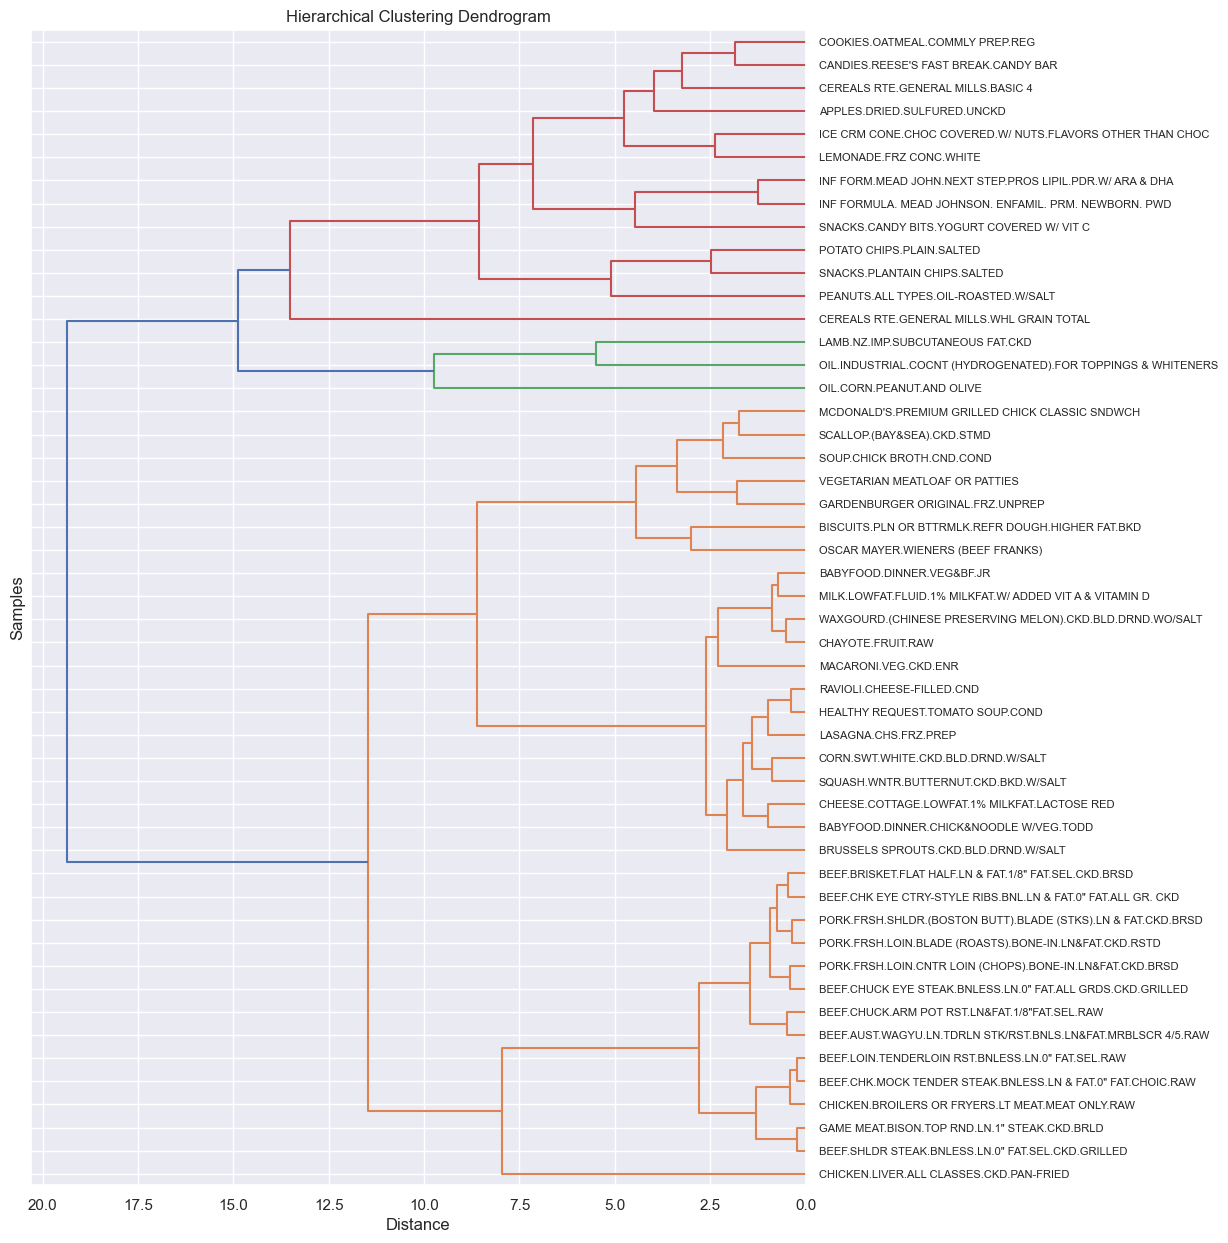

In [26]:
#On copie le DF :
df_Xsubset_2_copie = df_Xsubset_2.copy()

distance_matrix = squareform(pdist(df_Xsubset_2_copie, metric='euclidean'))

# Perform hierarchical clustering
linkage_matrix = linkage(df_Xsubset_2_copie, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 15))
dendrogram(linkage_matrix,
           orientation="left",
           labels=Xsubset.index.tolist(),
           leaf_font_size=8)

plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('Samples')
plt.xlabel('Distance')
plt.show()

**Q4 :**

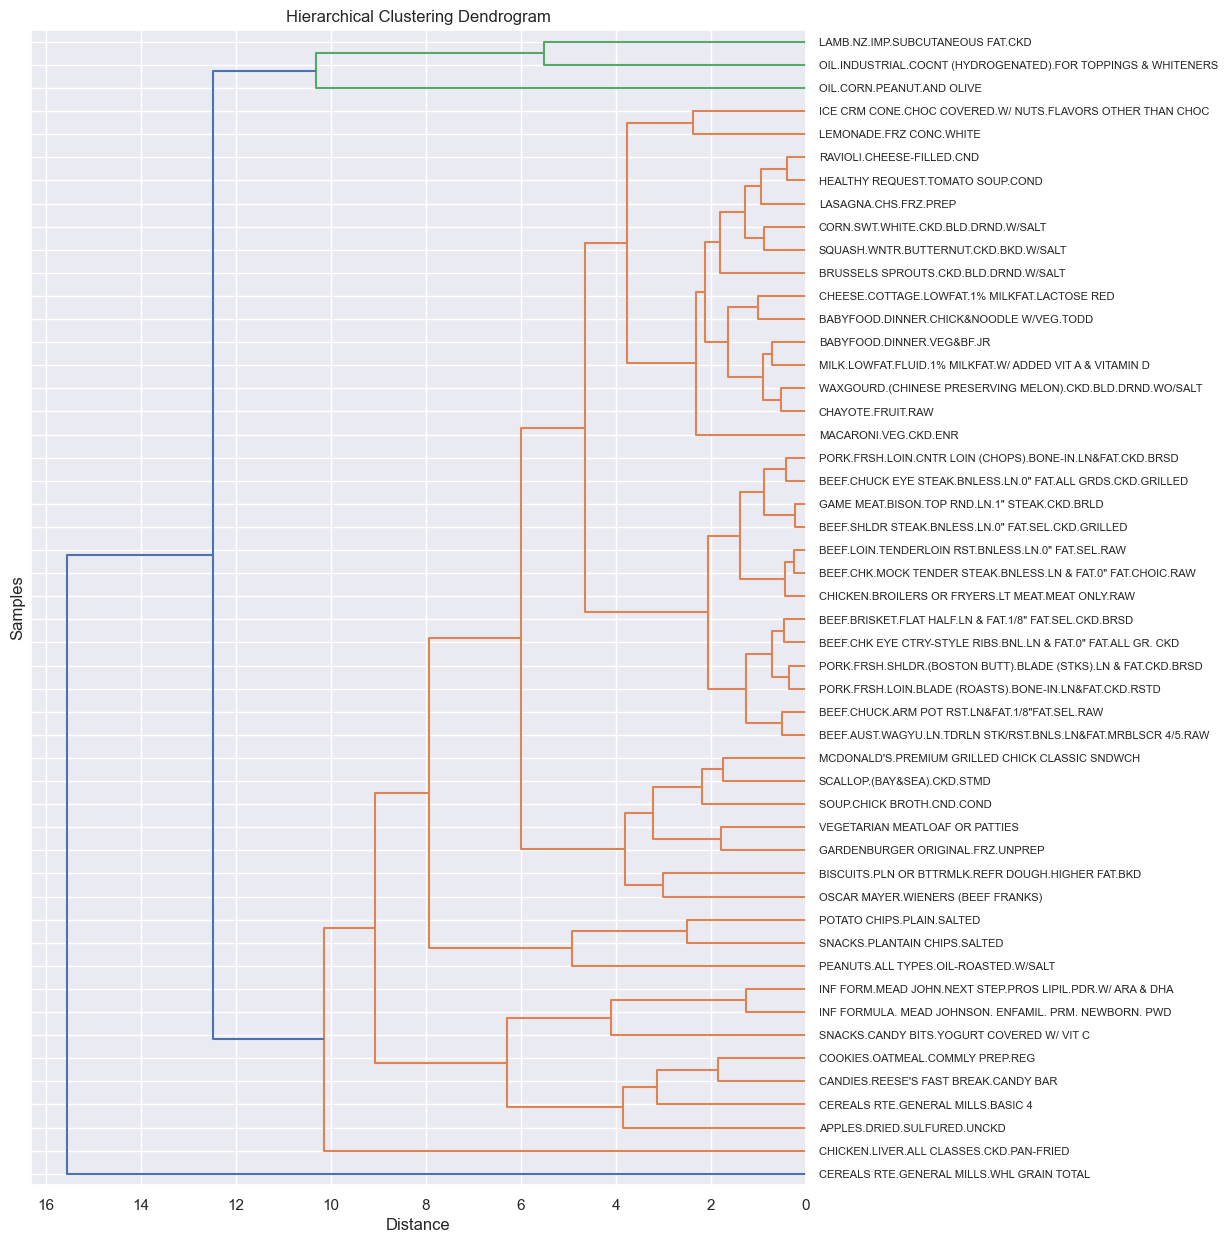

In [27]:
distance_matrix = squareform(pdist(df_Xsubset_2_copie, metric='minkowski'))

# COMPLETE LINKAGE + METRIQUE MINKWSKI :
linkage_matrix = linkage(df_Xsubset_2_copie, method='complete')

# Plot the dendrogram
plt.figure(figsize=(10, 15))
dendrogram(linkage_matrix,
           orientation="left",
           labels = Xsubset.index.tolist(),
         #  leaf_rotation="left",
           leaf_font_size=8)
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('Samples')
plt.xlabel('Distance')
plt.show()

# **K-Means**

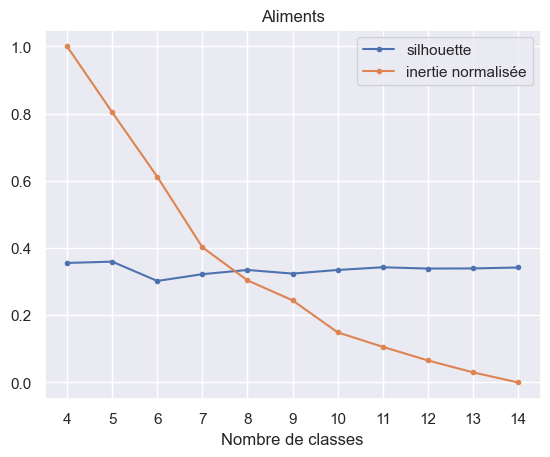

In [28]:
# List of number of clusters
range_n_clusters = np.arange(4,15)
inertia = []
silhouette = []
# For each number of clusters, perform Silhouette analysis and visualize the results.
for n_clusters in range_n_clusters:

    # Perform k-means.
    kmeans = KMeans(n_clusters=n_clusters, random_state=10)
    y_pred = kmeans.fit_predict(Xsubset_2)
    inertia.append(kmeans.inertia_)

    # Compute the Silhouette Coefficient for each sample.
    s = metrics.silhouette_samples(Xsubset_2, y_pred)
    # Compute the mean Silhouette Coefficient of all data points.
    s_mean = metrics.silhouette_score(Xsubset_2, y_pred)
    silhouette.append(s_mean)

plt.plot(range_n_clusters,silhouette,".-",label="silhouette")
plt.plot(range_n_clusters,(inertia-np.min(inertia))/(np.max(inertia)-np.min(inertia)),".-",label="inertie normalisée")
plt.xticks(range_n_clusters)
plt.xlabel("Nombre de classes")
plt.title("Aliments")
plt.legend()

**Q7: ACP**

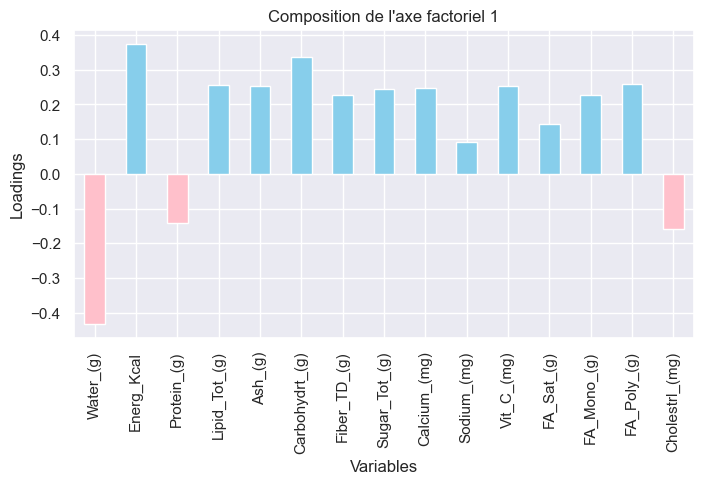

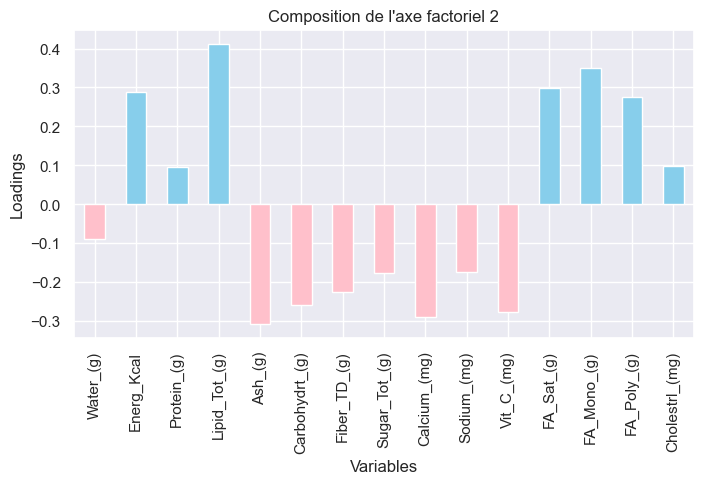

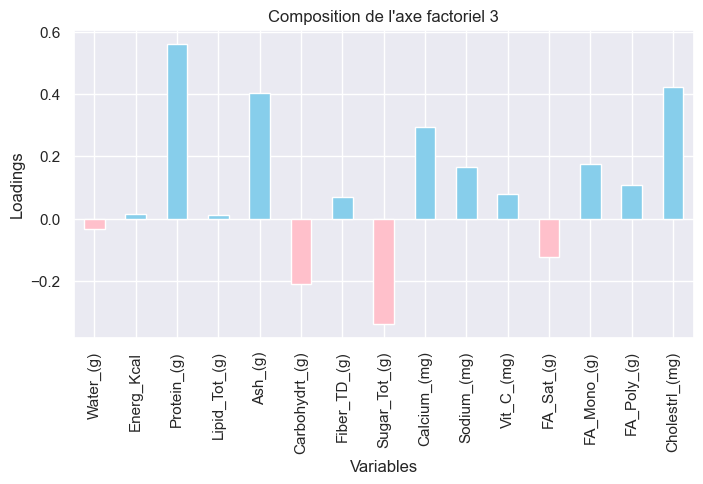

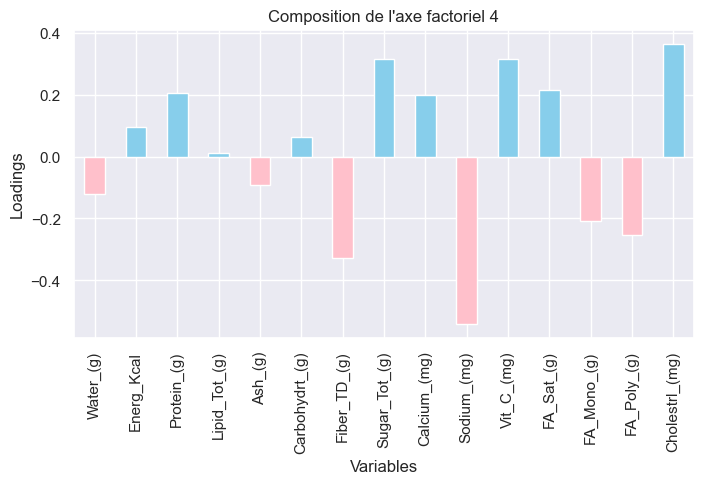

In [29]:
scale = StandardScaler()
Xsubset_2 = scale.fit_transform(Xsubset)  # Xsubset_2 est un tableau numpy

#On le convertit en datafame :
Xsubset_2 = pd.DataFrame(Xsubset_2, columns=Xsubset.columns)

# On réalise l'ACP :
pca = PCA()
pca.fit(Xsubset_2)
components = pca.fit_transform(Xsubset_2)

# Le nombre de variables qu'on garde :
K = 4

# On crée
loadings = pd.DataFrame(pca.fit(Xsubset_2).components_[0:K, :], columns=Xsubset_2.columns)

# On trace des diagrammes en barres pour chaque composante principale
for i in range(K):
    plt.figure(figsize=(8, 4))
    loadings_bar = loadings.iloc[i]

    # Spécifier les couleurs en fonction des valeurs des loadings
    colors = ['skyblue' if value > 0 else 'pink' for value in loadings_bar]

    loadings_bar.plot(kind='bar', color=colors)
    plt.title(f'Composition de l\'axe factoriel {i + 1}')
    plt.xlabel('Variables')
    plt.ylabel('Loadings')
    plt.show()

**Q8 : Boxplot**

In [30]:
kmeans= KMeans(n_clusters=8,
               n_init = 10,
               init='random',
               random_state = 70,
               verbose=True).fit(Xsubset_2)

df_Xsubset_2['Classe']=kmeans.labels_

Initialization complete
Iteration 0, inertia 424.72821459486664.
Iteration 1, inertia 299.7307447846343.
Iteration 2, inertia 283.1337314863968.
Iteration 3, inertia 258.5490976227248.
Iteration 4, inertia 255.3084140392885.
Iteration 5, inertia 253.32161183368862.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 412.76524488862657.
Iteration 1, inertia 280.74276269139096.
Iteration 2, inertia 266.51242056317477.
Iteration 3, inertia 260.0429581912083.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 357.35304641695996.
Iteration 1, inertia 254.10606776941762.
Iteration 2, inertia 251.56883540159868.
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 529.4078726384024.
Iteration 1, inertia 361.2686385053873.
Iteration 2, inertia 329.3178147055742.
Iteration 3, inertia 310.86094112189346.
Iteration 4, inertia 309.463022821519.
Iteration 5, inertia 308.8629520093363

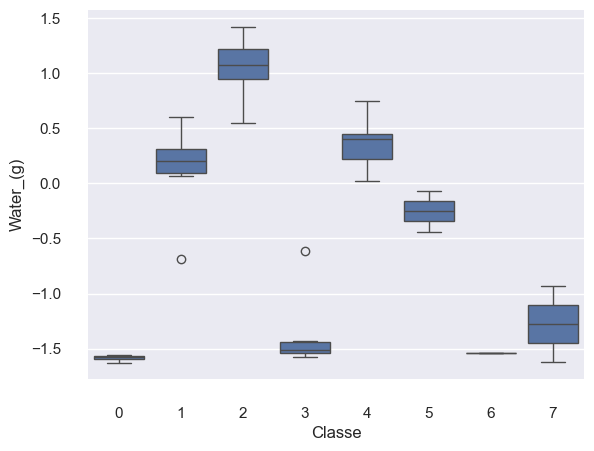

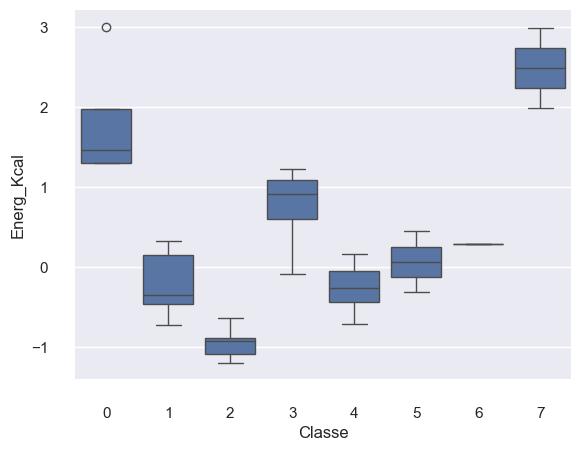

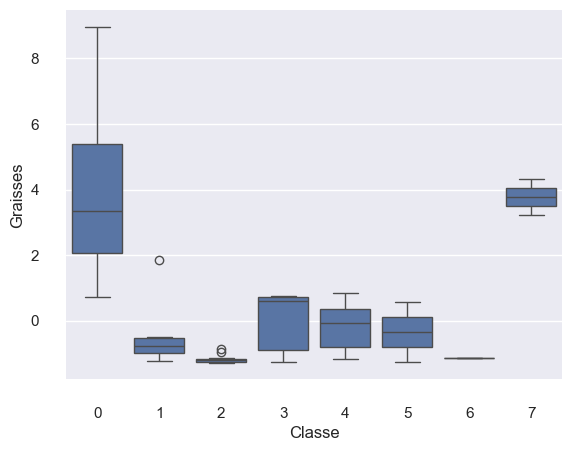

In [31]:
sns.boxplot(x="Classe",y="Water_(g)",
            data=df_Xsubset_2)
sns.despine(offset=10, trim=True)
plt.show()

sns.boxplot(x="Classe",y="Energ_Kcal",
            data=df_Xsubset_2)
sns.despine(offset=10, trim=True)
plt.show()

# On va additionner les deux variables Lipides et graisses monoinsaturées pour regarder l'axe 2.
df_Xsubset_2_copie["Graisses"]=df_Xsubset_2_copie["FA_Mono_(g)"]+df_Xsubset_2_copie["Lipid_Tot_(g)"]
df_Xsubset_2_copie["Classe"] = df_Xsubset_2["Classe"]

sns.boxplot(x="Classe",y="Graisses",
            data=df_Xsubset_2_copie)
sns.despine(offset=10, trim=True)
plt.show()

In [32]:
individus_classe_4 = df_Xsubset_2_copie[df_Xsubset_2_copie['Classe'] == 4]
individus_classe_4

,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),Sodium_(mg),Vit_C_(mg),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),Graisses,Classe
1,0.443227,-0.262301,0.780164,-0.040084,-0.376383,-0.777799,-0.680249,-0.538625,-0.271442,-0.681652,-0.360383,0.014523,0.128226,-0.363627,0.258642,0.088142,4
4,0.685409,-0.623930,0.925318,-0.440479,-0.257786,-0.777799,-0.680249,-0.538625,-0.256981,-0.604588,-0.360383,-0.283143,-0.312000,-0.344739,0.342851,-0.752479,4
5,0.443862,-0.426240,1.375492,-0.384307,-0.133799,-0.735613,-0.680249,-0.538625,-0.259047,-0.564028,-0.291098,-0.284391,-0.445617,-0.223589,6.321693,-0.829924,4
11,0.238182,-0.030859,1.229357,0.077652,-0.333257,-0.777799,-0.680249,-0.538625,-0.215666,-0.628924,-0.360383,-0.000526,0.190293,0.005357,0.535329,0.267945,4
18,0.021393,0.171653,1.562820,0.250213,-0.408728,-0.777799,-0.680249,-0.538625,-0.246653,-0.673540,-0.360383,0.227698,0.588022,-0.166161,0.691717,0.838234,4
20,0.692074,-0.604643,1.020453,-0.444074,-0.333257,-0.777799,-0.680249,-0.538625,-0.250784,-0.766828,-0.360383,-0.308396,-0.396156,-0.393390,0.282702,-0.840230,4
27,0.303251,-0.247836,1.587339,-0.188379,-0.370992,-0.777799,-0.680249,-0.538625,-0.244587,-0.632980,-0.360383,-0.079071,0.034947,-0.373358,0.595478,-0.153432,4
30,0.215964,-0.088720,1.613820,-0.066148,-0.268568,-0.777799,-0.680249,-0.538625,-0.166088,-0.641092,-0.360383,-0.071437,0.054995,-0.053787,0.511269,-0.011153,4
31,0.068369,0.094506,1.688358,0.107311,-0.424900,-0.777799,-0.680249,-0.538625,-0.244587,-0.738436,-0.360383,0.072001,0.285973,-0.342450,0.824046,0.393285,4
34,0.369589,-0.103185,0.742895,0.108210,-0.468026,-0.777799,-0.680249,-0.538625,-0.242521,-0.685708,-0.360383,0.081397,0.281531,-0.338825,0.655628,0.389741,4


# **DBSCAN**

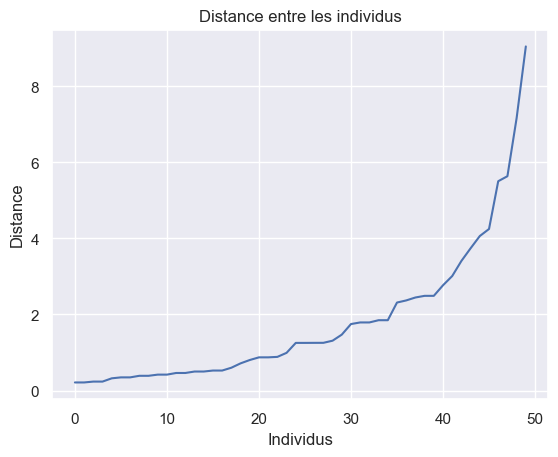

In [33]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

neighbors = NearestNeighbors(n_neighbors=3)
neighbors_fit = neighbors.fit(Xsubset_2)
distances, indices = neighbors_fit.kneighbors(Xsubset_2)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.title ('Distance entre les individus')
plt.xlabel('Individus')
plt.ylabel('Distance')

plt.plot(distances)

In [34]:
y_pred = DBSCAN(eps=2.5, min_samples=2).fit_predict(Xsubset_2)
y_pred = y_pred+2
y_pred

array([1, 2, 1, 3, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 1, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 4, 2, 3, 2, 3, 2, 2, 3,
       2, 4, 2, 2, 1, 2])

In [35]:
# on sélectionne les deux premières composantes principales
components_2d = components[:, :2]

#DataFrame avec les deux composantes principales et les clusters
df = pd.DataFrame(components_2d, columns=['Composante principale 1', 'Composante principale 2'])
df['Cluster'] = y_pred
df["Nom"] = Xsubset.index.tolist()
# graphique
fig = px.scatter(df, x='Composante principale 1',
                 y='Composante principale 2',
                 color='Cluster',
                 color_continuous_scale='Spectral',
                 hover_name = df["Nom"])

# titre et graphe
fig.update_layout(xaxis_title="Composante principale 1", yaxis_title="Composante principale 2", title="Visualisation des clusters : METHODE DBSCAN")

fig.show()

In [36]:
df_Xsubset_2_copie["PC1"]= components[:, 0]
df_Xsubset_2_copie['PC2'] = components[:, 1]

df = df_Xsubset_2_copie[['PC1', 'PC2', 'Classe']]
df["Nom"] = Xsubset.index.tolist()

fig = px.scatter(df, x='PC1', y='PC2', color='Classe', hover_name = df["Nom"]) #color_continuous_scale='Spectral')

# titres des axes
fig.update_layout(xaxis_title="Composante principale 1", yaxis_title="Composante principale 2", title="Diagramme des composantes principales : METHODE KMEANS")

fig.show()

/var/folders/cx/_4n5cr695vzf97zwdxs2hhqh0000gn/T/ipykernel_3160/1977421760.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

